In [55]:
!conda install pandas numpy matplotlib scipy

^C


In [ ]:
!pip install yfinance yahoofinancials

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
import yfinance as yf
from yahoofinancials import YahooFinancials

In [3]:
import datetime

In [4]:
plt.rcParams["figure.figsize"] = (20,10)

In [5]:
dt = datetime.datetime
td = datetime.timedelta

In [6]:
clinton_inaguration = datetime.datetime(year=1993, month=1, day=20)
bush_inaguration = datetime.datetime(year=2001, month=1, day=20)
obama_inaguration = datetime.datetime(year=2009, month=1, day=20)
obama_second_inaguration = datetime.datetime(year=2013, month=1, day=20)
trump_inaguration = datetime.datetime(year=2017, month=1, day=20)
covid_begins = datetime.datetime(year=2020, month=2, day=18)

In [7]:
STOCK = "SPY"

In [8]:
LOG0 = False
LOG1 = False

# Unemployment

Source: Civilian Unemployment Rate from the U.S. Bureau of Labor Statistics
https://www.bls.gov/charts/employment-situation/civilian-unemployment-rate.htm

In [9]:
unemployment = pd.read_csv("./BLS.csv", index_col="Month", parse_dates=True, infer_datetime_format=True)['Total']
unemployment.index = pd.to_datetime(unemployment.index, format="%b-%y")
unemployment.name = "Unemployment"
unemployment.index.name = "Date"
unemployment.head()

Date
2000-08-01    4.1
2000-09-01    3.9
2000-10-01    3.9
2000-11-01    3.9
2000-12-01    3.9
Name: Unemployment, dtype: float64

In [10]:
bush_unemployment_mask = (unemployment.index >= bush_inaguration) & (unemployment.index < obama_inaguration)
obama_unemployment_mask = (unemployment.index >= obama_inaguration) & (unemployment.index < trump_inaguration)
trump_unemployment_mask = (unemployment.index >= trump_inaguration)
covid_mask = (unemployment.index >= covid_begins)

In [11]:
unemployment = pd.DataFrame(unemployment)
unemployment['President'] = ""
unemployment["COVID"] = covid_mask
unemployment.loc[bush_unemployment_mask, "President"] = "Bush"
unemployment.loc[obama_unemployment_mask, "President"] = "Obama"
unemployment.loc[trump_unemployment_mask, "President"] = "Trump"
unemployment = unemployment[unemployment.index > bush_inaguration]
unemployment = unemployment.reset_index()

In [12]:
bush_unemployment = unemployment[unemployment["President"]=="Bush"]
obama_unemployment = unemployment[unemployment["President"]=="Obama"]
trump_unemployment = unemployment[unemployment["President"]=="Trump"]
trump_unemployment_precovid = unemployment[(unemployment['COVID']==False) & (unemployment["President"]=="Trump")]

In [13]:
def plot_trendline0(df, ax, *, color, label):
    x = np.array(df['Date'].map(datetime.date.toordinal))
    if not LOG0:
        slope, y0, r, p, stderr = stats.linregress(x,
                                               df['Unemployment'])
        x_endpoints = pd.DataFrame(np.linspace(x[0], x[-1], 100))
        y_endpoints = y0 + slope * x_endpoints
        ax.plot(x_endpoints, y_endpoints, color=color, label=label, linestyle="dashed")
    else:
        (a, b), _ = sp.optimize.curve_fit(lambda t,a,b: np.exp(a+b*np.log(t)),  x,  df['Unemployment'])
        x_endpoints = pd.DataFrame(np.linspace(x[0], x[-1], 100))
        y_endpoints = np.exp(a+b*np.log(x_endpoints))
        ax.semilogy(x_endpoints, y_endpoints, color=color, label=label, linestyle="dashed")

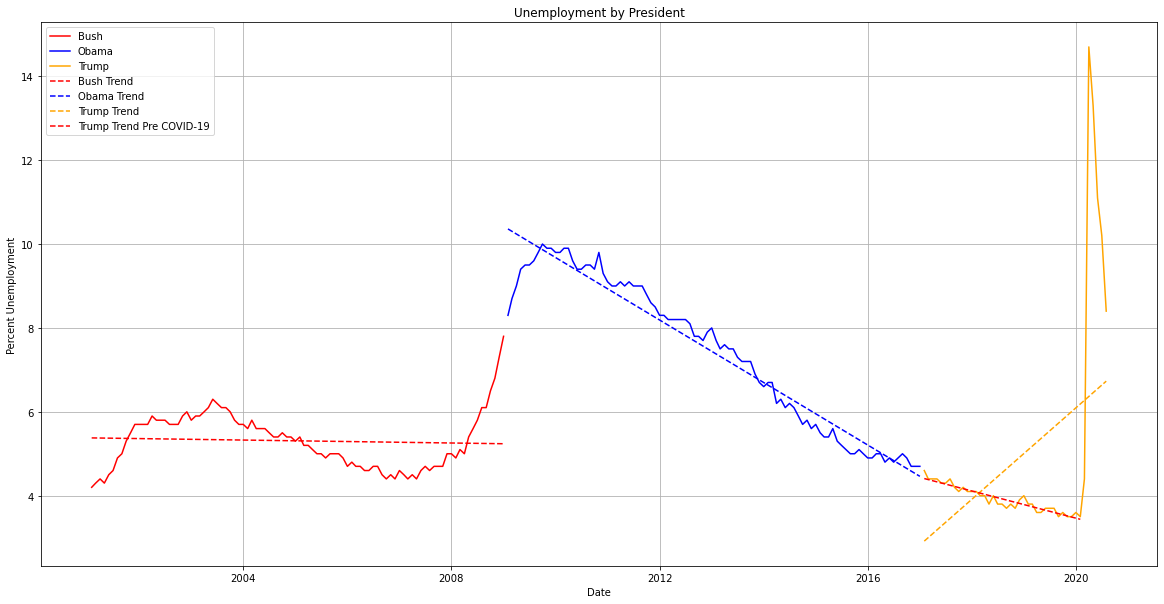

In [14]:
fig, ax = plt.subplots()
if LOG0:
    ax.semilogy(bush_unemployment["Date"], bush_unemployment["Unemployment"], color="red", label="Bush")
    ax.semilogy(obama_unemployment["Date"], obama_unemployment["Unemployment"], color="blue", label="Obama")
    ax.semilogy(trump_unemployment["Date"], trump_unemployment["Unemployment"], color="orange", label="Trump")
else:
    ax.plot(bush_unemployment["Date"], bush_unemployment["Unemployment"], color="red", label="Bush")
    ax.plot(obama_unemployment["Date"], obama_unemployment["Unemployment"], color="blue", label="Obama")
    ax.plot(trump_unemployment["Date"], trump_unemployment["Unemployment"], color="orange", label="Trump")

plot_trendline0(bush_unemployment, ax, color="red", label="Bush Trend")
plot_trendline0(obama_unemployment, ax, color="blue", label="Obama Trend")
plot_trendline0(trump_unemployment, ax, color="orange", label="Trump Trend")
plot_trendline0(trump_unemployment_precovid, ax, color="red", label="Trump Trend Pre COVID-19")

ax.grid(True, which="both")
ax.set_title("Unemployment by President")
ax.set_xlabel("Date")
ax.set_ylabel("Percent Unemployment")
ax.legend()

# Stocks

In [15]:
stocks = yf.download(STOCK, 
                      start=clinton_inaguration, 
                      end=datetime.datetime.now(), 
                      progress=False)
stocks["Avg"] = stocks[["High", "Low"]].mean(axis=1)
stocks = stocks["Avg"]
stocks.head()

Date
1993-01-29    43.859375
1993-02-01    44.109375
1993-02-02    44.250000
1993-02-03    44.609375
1993-02-04    44.781250
Name: Avg, dtype: float64

In [16]:
clinton_stocks_mask = (stocks.index >= clinton_inaguration) & (stocks.index < bush_inaguration)
bush_stocks_mask = (stocks.index >= bush_inaguration) & (stocks.index < obama_inaguration)
obama_stocks_mask = (stocks.index >= obama_inaguration) & (stocks.index < trump_inaguration)
trump_stocks_mask = (stocks.index >= trump_inaguration)
covid_mask = (stocks.index >= covid_begins)

In [17]:
stocks = pd.DataFrame(stocks)
stocks['President'] = ""
stocks["COVID"] = covid_mask
stocks.loc[clinton_stocks_mask, "President"] = "Clinton"
stocks.loc[bush_stocks_mask, "President"] = "Bush"
stocks.loc[obama_stocks_mask, "President"] = "Obama"
stocks.loc[trump_stocks_mask, "President"] = "Trump"
stocks = stocks[stocks.index > clinton_inaguration]
stocks = stocks.reset_index()

In [18]:
clinton_stocks = stocks[stocks["President"]=="Clinton"]
bush_stocks = stocks[stocks["President"]=="Bush"]
obama_stocks = stocks[stocks["President"]=="Obama"]
trump_stocks = stocks[stocks["President"]=="Trump"]
trump_stocks_precovid = stocks[(stocks['COVID']==False) & (stocks["President"]=="Trump")]

In [19]:
def plot_trendline1(df, ax, *, color, label):
    if len(df):
        df = df.copy()
        df.index = np.array(df['Date'].map(datetime.date.toordinal))
        del df["Date"]
       
        if LOG1:
            (a, b), _ = sp.optimize.curve_fit(lambda t,a,b: np.exp(a+b*np.log(t)),  df.index,  df['Avg'])
            x_endpoints = pd.DataFrame(np.linspace(df.index[0], df.index[-1], 100))
            y_endpoints = np.exp(a+b*np.log(x_endpoints))
            ax.semilogy(x_endpoints, y_endpoints, color=color, label=label, linestyle="dashed")
        else:
            slope, y0, r, p, stderr = stats.linregress(df.index,
                                            df['Avg'])
            x_endpoints = pd.DataFrame(np.linspace(df.index[0], df.index[-1], 100))
            y_endpoints = df["Avg"] + slope * x_endpoints
            ax.plot(x_endpoints, y_endpoints, color=color, label=label, linestyle="dashed")

In [75]:
fig, ax = plt.subplots()
ax.semilogy(clinton_stocks["Date"], clinton_stocks["Avg"], color="blue", label="Clinton")
ax.semilogy(bush_stocks["Date"], bush_stocks["Avg"], color="red", label="Bush")
ax.semilogy(obama_stocks["Date"], obama_stocks["Avg"], color="blue", label="Obama")
ax.semilogy(trump_stocks["Date"], trump_stocks["Avg"], color="orange", label="Trump")

plot_trendline1(clinton_stocks, ax, color="blue", label="Clinton Trend")
plot_trendline1(bush_stocks, ax, color="red", label="Bush Trend")
plot_trendline1(obama_stocks, ax, color="blue", label="Obama Trend")
plot_trendline1(trump_stocks, ax, color="orange", label="Trump Trend")
# plot_trendline(trump_stocks_precovid, ax, color="orange", label="Trump Trend Pre COVID-19")

ax.grid(True, which="both")
ax.set_title(f"{STOCK} by President")
ax.set_xlabel("Date")
ax.set_ylabel("Dollars $$$")
ax.legend()

Error in callback <function flush_figures at 0x000002658AF393A0> (for post_execute):


KeyboardInterrupt: 

## Whatif

In [22]:
def whatif(buydate, selldate):
    start_price = yf.download("SPY", start=buydate, end=buydate+td(days=5)).iloc[0]['Open']
    end_price = yf.download("SPY", start=selldate, end=selldate+td(days=5)).iloc[0]['Open']
    print(str(end_price/start_price*100)+"% earnings")

### You bought stock on Obamas first inaguration and sold before his second

In [23]:
whatif(obama_inaguration, obama_second_inaguration-td(days=1))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
176.10114676416495% earnings


### You bought stock on Obamas second inaguration and sold before Trump's inaguration

In [24]:
whatif(obama_second_inaguration, trump_inaguration-td(days=1))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
152.92927495292386% earnings


### You bought stock on Trumps inaguration and sold before COVID-19

In [25]:
whatif(trump_inaguration, covid_begins-td(days=1))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
148.4384712375861% earnings


### You bought stock on Trumps inaguration and sold Today

In [26]:
whatif(trump_inaguration, datetime.datetime.now())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
147.93559754381283% earnings


## Notable Events

In [27]:
notable = [
    dt(month=12, day=22, year=2017),
    dt(month=1, day=26, year=2018),
    dt(month=9, day=28, year=2018),
    dt(month=11, day=2, year=2018),
    dt(month=12, day=21, year=2018),
    dt(month=5, day=3, year=2019),
    dt(month=5, day=31, year=2019),
    dt(month=7, day=26, year=2019),
    dt(month=8, day=23, year=2019),
    dt(month=2, day=21, year=2020),
    dt(month=3, day=20, year=2020)
]

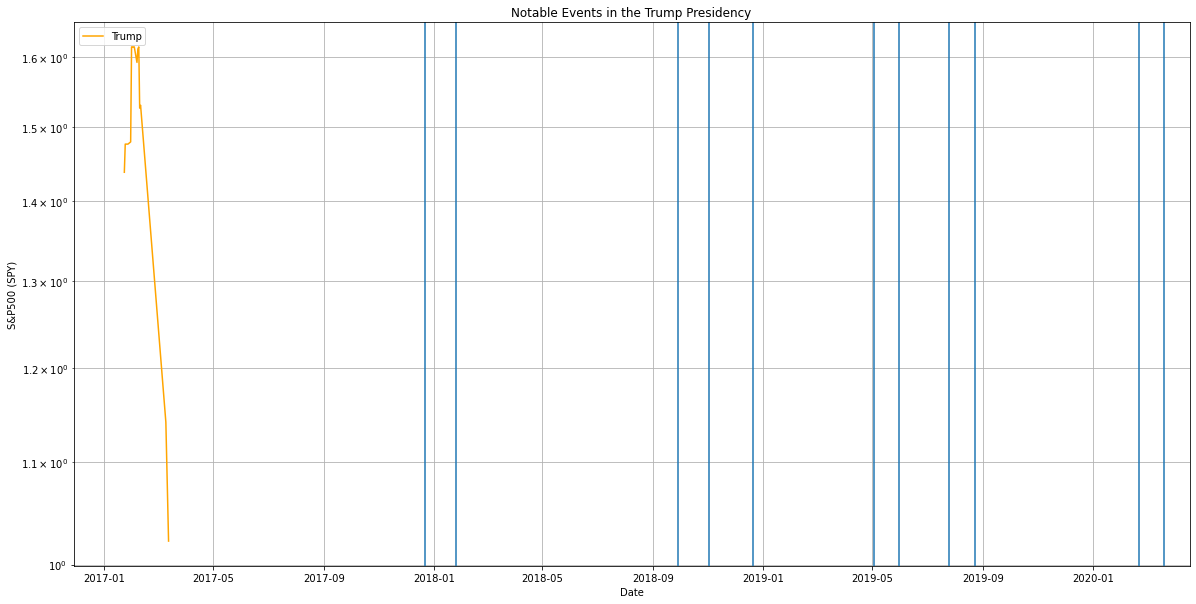

In [28]:
fig, ax = plt.subplots()
ax.semilogy(trump_stocks["Date"], trump_stocks["Avg"], color="orange", label="Trump")
#plot_trendline1(trump_stocks, ax, color="orange", label="Trump Trend")
for date in notable:
    ax.axvline(date)
ax.grid(True, 'both')
ax.set_title("Notable Events in the Trump Presidency")
ax.set_ylabel("S&P500 (SPY)")
ax.set_xlabel("Date")
ax.legend()

Nov 4th 2016 - The day after the election, the market is at it's low. It goes
right back up again, but just remember that this happens around every election.
You can win money betting against the market on election day NO MATTER WHO WINS
because uncertainty is bad for stocks. Just an FYI. A few days after Fox reports
record high markets, but looked at historically it's barely a bump compared to
what's about to happen.
 
Linear growth for 1.2 years, 37% growth. For reference Nov 7 2008 through Jan 7 2011
gave Obama 36% growth. Look it up.
 
Dec 22nd 2017 - January 26th 2018 - 7% Growth - Tax reform bill is passed.

Jan 26th 2018 - March 23rd 2018 - 8% Drop - Donald trump tries to fire Robert Mueller,
A major steel tarrif is announced, and Trump's meeting in North Korea together
crash the stock market by 8% removing any gains made by the tax bill. 
 
Sept 28th 2018 - Nov 2nd 2018 - 7% Drop - Donald Trump renegotiates NAFTA. Kavenau joins
the supreme court.
 
Nov 2nd 2018 - Dec 21st 2018 - 9% Drop - Democrats win the House, Donald Trump shuts down
the economy in longest government shutdown in US history in order to pay for his
border wall.
 
May 3rd 2019 - May 31st 2019 - 7% drop - The Trump administration is having a
fight with China, raising $200 billion of tarrifs on Chinese Imports. Meanwhile,
Trump is failing to comply with lawful supenas from the House during the Muller
probe. The Muller report ends May 29th with Muller's resignation, being released two weeks later.
 
July 26th 2019 - Aug 23rd 2019 - 6% drop - Donald Trump beings using Emergency
Powers to construct his border wall. The El Paso shooting happens, and one day
later the Oregon shooting happens, 32 people die altogether. Trump rolls back
legal green card immigration on August 12th effecting employers like mine.
Finally on August 23rd, Trump asserts he has the right to order US companies to
stop doing buisness with China.
 
Feb 21st 2020 - Mar 20 2020 - 30% COVID 19 drop bringing stocks back to Feb 3rd 2017
levels, just one month after his inaguration. Every president deals with
national crisis, and this president did nothing. MONEY ISN'T EVERYTHING when you
are electing a president, capitalism vs socialism isn't everything, how they
deal with a national crisis is the most important element of a commander in cheif. I said that in 2016.
 
Since then stocks are back to normal, but IMO this is a bubble. We are not over
COVID and the economy is lying to itself about the effects. Biden will likely
see a drop when he's elected and inevidably has to shut down the country
responsibly over COVID, so take that for what you will, but the loss of lives
has a long term economic impact that is much worse in case you are wondering
about lives in terms of dollars and cents. Also most older people vote for Trump
and they are the ones disproportionately dying from his inaction.
 
January 20 2017 - August 24 2020 - President Trump
1312 Days in Office - 51% Growth - 0.03% Growth Per Day
 
January 9 2009 - August 12 2016 - President Obama
2772 Days in Office - 145.3% Growth - 0.05% Growth Per Day

# Deficit

https://datalab.usaspending.gov/americas-finance-guide/deficit/trends/

In [29]:
deficit = pd.read_csv('./federal_deficit_trends.csv')[["year", 'federal_deficit']]
deficit = deficit.rename(columns={'year': "Date", 'federal_deficit': "Deficit"})
deficit["Deficit"] = -deficit["Deficit"]
deficit["Date"] = deficit["Date"].map(lambda x: dt(month=12, day=31, year=x))
deficit = deficit.append({"Date": dt(month=12, day=31, year=2020), "Deficit": 3.3e12}, ignore_index=True)
deficit = deficit.set_index("Date")
deficit.head()

,Deficit
Date,
2000-12-31,-2.369930e+11
2001-12-31,-1.271650e+11
2002-12-31,1.585200e+11
2003-12-31,3.742190e+11
2004-12-31,4.125530e+11


In [30]:
bush_deficit_mask = (deficit.index >= bush_inaguration) & (deficit.index < obama_inaguration)
obama_deficit_mask = (deficit.index >= obama_inaguration) & (deficit.index < trump_inaguration)
trump_deficit_mask = (deficit.index >= trump_inaguration)
covid_mask = (deficit.index >= covid_begins)

In [31]:
deficit = pd.DataFrame(deficit)
deficit['President'] = ""
deficit["COVID"] = covid_mask
deficit.loc[bush_deficit_mask, "President"] = "Bush"
deficit.loc[obama_deficit_mask, "President"] = "Obama"
deficit.loc[trump_deficit_mask, "President"] = "Trump"
deficit = deficit[deficit.index > bush_inaguration]
deficit = deficit.reset_index()
deficit["Date"] -= td(days=365//2)
deficit.head()

,Date,Deficit,President,COVID
0,2001-07-02,-1.271650e+11,Bush,False
1,2002-07-02,1.585200e+11,Bush,False
2,2003-07-02,3.742190e+11,Bush,False
3,2004-07-02,4.125530e+11,Bush,False
4,2005-07-02,3.186150e+11,Bush,False


In [32]:
bush_deficit = deficit[deficit["President"]=="Bush"]
obama_deficit = deficit[deficit["President"]=="Obama"]
trump_deficit = deficit[deficit["President"]=="Trump"]
trump_deficit_precovid = deficit[(deficit['COVID']==False) & (deficit["President"]=="Trump")]

In [33]:
def plot_trendline2(df, ax, *, color, label):
    df = df.copy()
    df.index = np.array(df['Date'].map(datetime.date.toordinal))
    del df["Date"]
    std = df.rolling(1).std()['Deficit']
    mean = df.rolling(1).mean()['Deficit']
    slope, y0, r, p, stderr = stats.linregress(df.index,
                                               df['Deficit'])
    x_endpoints = pd.DataFrame(np.linspace(df.index[0], df.index[-1], 100))
    y_endpoints = y0 + slope * x_endpoints
    ax.plot(x_endpoints, y_endpoints, color=color, label=label, linestyle="dashed")

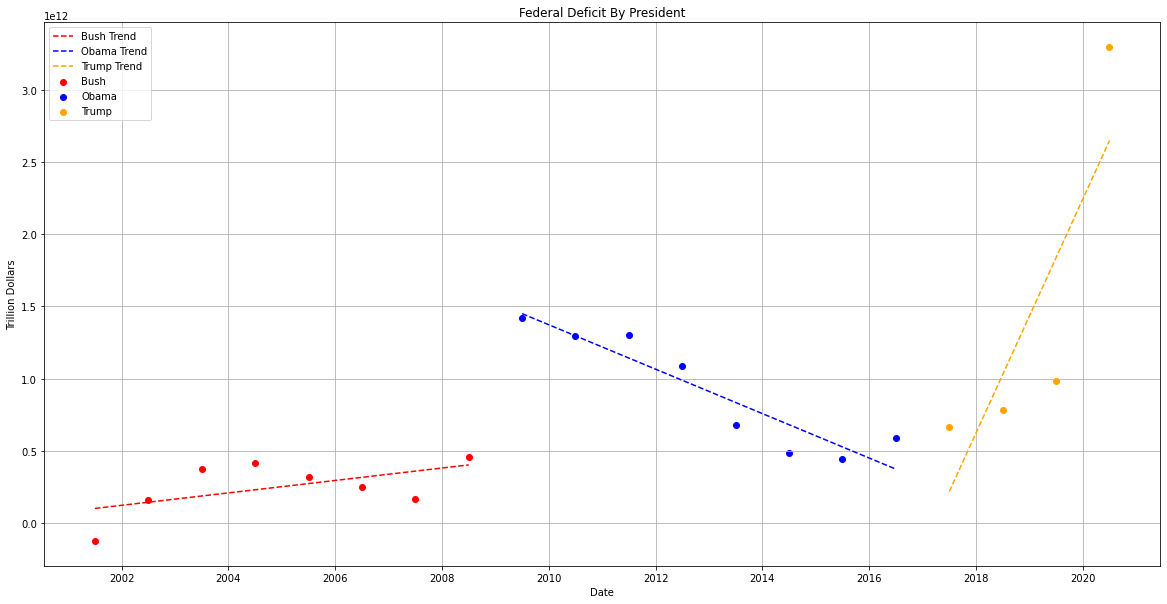

In [34]:
fig, ax = plt.subplots()
ax.scatter(bush_deficit["Date"], bush_deficit["Deficit"], color="red", label="Bush")
ax.scatter(obama_deficit["Date"], obama_deficit["Deficit"], color="blue", label="Obama")
ax.scatter(trump_deficit["Date"], trump_deficit["Deficit"], color="orange", label="Trump")

plot_trendline2(bush_deficit, ax, color="red", label="Bush Trend")
plot_trendline2(obama_deficit, ax, color="blue", label="Obama Trend")
plot_trendline2(trump_deficit, ax, color="orange", label="Trump Trend")

ax.grid(True, which="both")
ax.set_title("Federal Deficit By President")
ax.set_ylabel("Trillion Dollars")
ax.set_xlabel("Date")
ax.legend()

# All In One

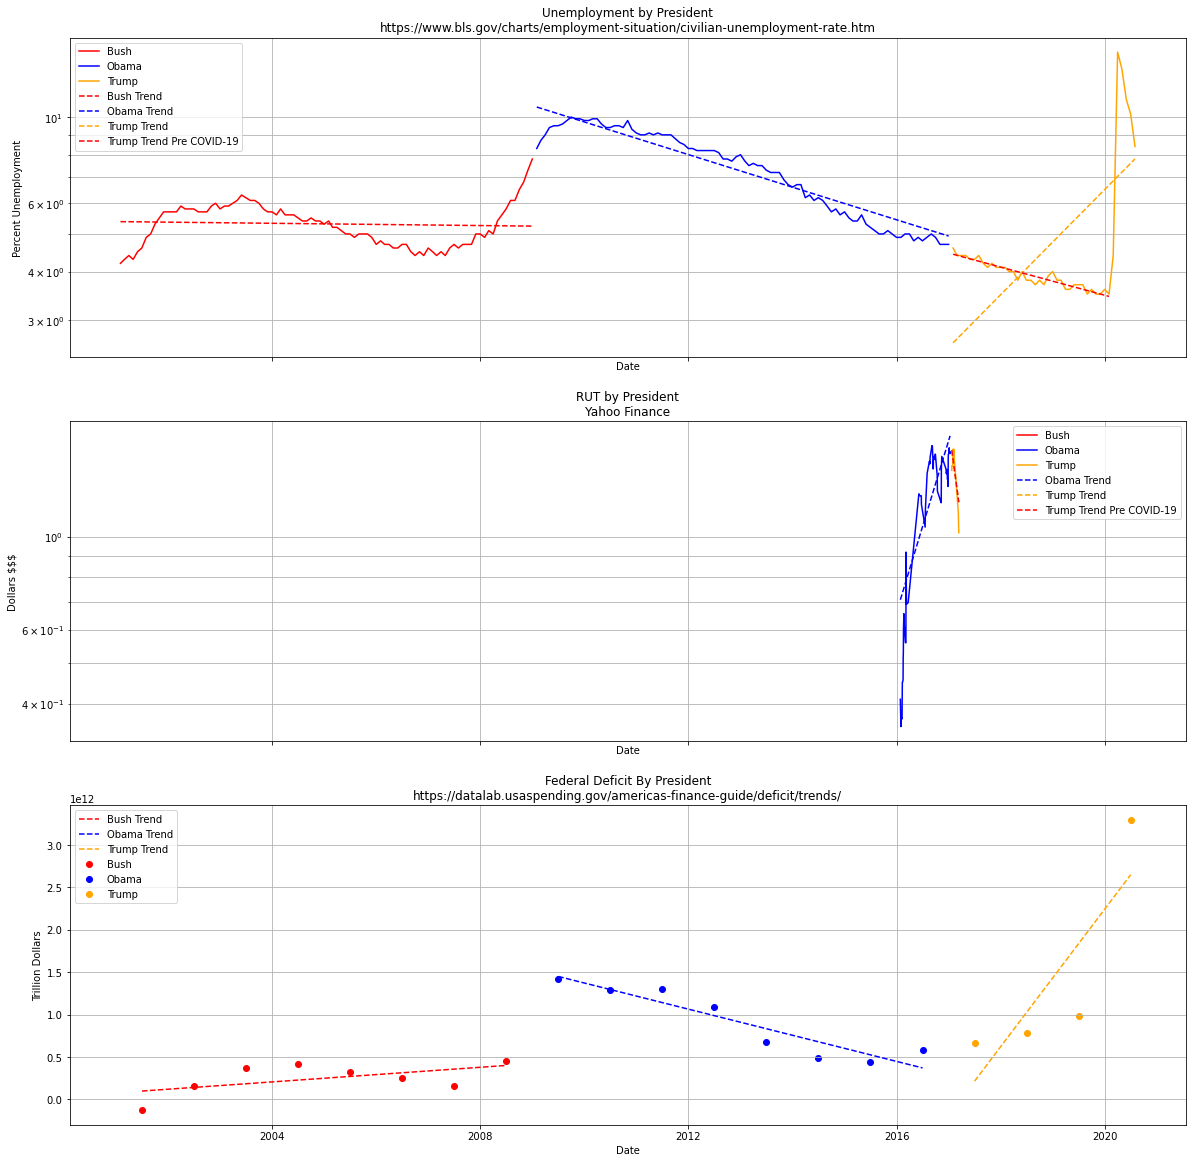

In [35]:
fig, (ax0, ax1, ax2) = plt.subplots(3, figsize=(20,20), sharex=True)
ax0.semilogy(bush_unemployment["Date"], bush_unemployment["Unemployment"], color="red", label="Bush")
ax0.semilogy(obama_unemployment["Date"], obama_unemployment["Unemployment"], color="blue", label="Obama")
ax0.semilogy(trump_unemployment["Date"], trump_unemployment["Unemployment"], color="orange", label="Trump")

plot_trendline0(bush_unemployment, ax0, color="red", label="Bush Trend")
plot_trendline0(obama_unemployment, ax0, color="blue", label="Obama Trend")
plot_trendline0(trump_unemployment, ax0, color="orange", label="Trump Trend")
plot_trendline0(trump_unemployment_precovid, ax0, color="red", label="Trump Trend Pre COVID-19")

ax0.grid(True, which="both")
ax0.set_title("Unemployment by President\nhttps://www.bls.gov/charts/employment-situation/civilian-unemployment-rate.htm")
ax0.set_xlabel("Date")
ax0.set_ylabel("Percent Unemployment")
ax0.legend()

ax1.semilogy(bush_stocks["Date"], bush_stocks["Avg"], color="red", label="Bush")
ax1.semilogy(obama_stocks["Date"], obama_stocks["Avg"], color="blue", label="Obama")
ax1.semilogy(trump_stocks["Date"], trump_stocks["Avg"], color="orange", label="Trump")

plot_trendline1(bush_stocks, ax1, color="red", label="Bush Trend")
plot_trendline1(obama_stocks, ax1, color="blue", label="Obama Trend")
plot_trendline1(trump_stocks, ax1, color="orange", label="Trump Trend")
plot_trendline1(trump_stocks_precovid, ax1, color="red", label="Trump Trend Pre COVID-19")

ax1.grid(True, which="both")
ax1.set_title(f"{STOCK} by President\nYahoo Finance")
ax1.set_xlabel("Date")
ax1.set_ylabel("Dollars $$$")
ax1.legend()

ax2.scatter(bush_deficit["Date"], bush_deficit["Deficit"], color="red", label="Bush")
ax2.scatter(obama_deficit["Date"], obama_deficit["Deficit"], color="blue", label="Obama")
ax2.scatter(trump_deficit["Date"], trump_deficit["Deficit"], color="orange", label="Trump")

plot_trendline2(bush_deficit, ax2, color="red", label="Bush Trend")
plot_trendline2(obama_deficit, ax2, color="blue", label="Obama Trend")
plot_trendline2(trump_deficit, ax2, color="orange", label="Trump Trend")

ax2.grid(True, which="both")
ax2.set_title("Federal Deficit By President\nhttps://datalab.usaspending.gov/americas-finance-guide/deficit/trends/")
ax2.set_ylabel("Trillion Dollars")
ax2.set_xlabel("Date")
ax2.legend()